In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap
from tqdm import tqdm

In [12]:
import rasterio
from rasterio.plot import show
import rasterio
from rasterio.enums import Resampling
# 18.4 sec

In [3]:
COLOUR = ['#1E90FF', # 0 # Dodgerblue
          '#FFBF00', # 1 # Amber
          '#FF6347', # 2 # Tomato
          '#00A86B', # 3 # Jade
          '#8A2BE2', # 4 # Blueviolet
          '#FF6FFF', # 5 # Ultra Pink
          '#00CCFF', # 6 # Vivid Sky Blue
          '#00ff40', # 7 # Erin
          '#FF004F', # 8 # Folly
          '#0063A6', # 9 # Lapis Lazuli
        ]
def setMplParam(classNum):
    # Define effective colors, line styles, and markers based on the class number
   
    LINE = ['-', '-.', '--', '-.', ':','--','-.','-', ':', '--']
    MARKER = ['.','*', '^', 's', '.', 'p', 'o', 's', '.', 'd']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]

    # Set the color cycle for lines including color, line style, and marker
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                       plt.cycler(linestyle=LINE_EFF)+
                                       plt.cycler(marker=MARKER_EFF))

    # Set default line and marker sizes
    plt.rcParams['lines.markersize'] = 3  # Example size
    plt.rcParams['lines.linewidth'] = 2   # Example width for lines

    # Set label and title sizes
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    # Set tick properties
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20

    # Set legend font size
    plt.rcParams['legend.fontsize'] = 12

    # Enable and configure grid
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    # Set axes line width
    plt.rcParams['axes.linewidth'] = 2

    # Set tick sizes and widths
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['xtick.major.width'] = 3
    plt.rcParams['xtick.minor.size'] = 2
    plt.rcParams['xtick.minor.width'] = 2

    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['ytick.major.width'] = 3
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.minor.width'] = 2

setMplParam(10)


In [4]:
def readCityLocation():
    fileName = 'city_locations.txt'
    data = pd.read_csv(fileName, sep=',', 
        names=['City', 'Latitude', 'Longitude', "Area"], 
        dtype={'City':str, 'Latitude':float, 'Longitude':float, 'Area':float})
    return data

data = readCityLocation()
print(data)

             City  Latitude  Longitude      Area
0    Buenos Aires  -34.6037   -58.3816    203.00
1         Chicago   41.8781   -87.6298    606.00
2      Copenhagen   55.6761    12.5683     88.00
3          Dublin   53.3498    -6.2603    115.00
4         Jakarta   -6.2088   106.8456    662.00
5          London   51.5074    -0.1278   1572.00
6     Los Angeles   34.0522  -118.2437   1302.00
7       Melbourne  -37.8136   144.9631   9996.00
8     Mexico City   19.4326   -99.1332   1485.00
9          Moscow   55.7558    37.6173   2561.00
10         Mumbai   19.0760    72.8777    603.00
11         Munich   48.1351    11.5820    310.70
12  New York City   40.7128   -74.0060    783.80
13          Paris   48.8566     2.3522    105.40
14         Riyadh   24.7136    46.6753   1975.00
15          Seoul   37.5665   126.9780    605.21
16       Shanghai   31.2304   121.4737   6340.00
17      Singapore    1.3521   103.8198    728.60
18      Stockholm   59.3293    18.0686    188.00
19         Sydney  -

In [1]:
def getEarth():
    RESOLUTION = 180 * 100
    latitudes = np.linspace(-90, 90, RESOLUTION)
    longitudes = np.linspace(-180, 180, RESOLUTION * 2)
    unitCellSize = latitudes[1] - latitudes[0]
    # If you need a meshgrid for plotting purposes
    lon, lat = np.meshgrid(longitudes, latitudes)
    return lat, lon, unitCellSize

In [6]:
# x = [lat, lon]
# y = [lat, lon]
def angularDistance(x, y):
    return np.sqrt(np.sum((x - y)**2, axis=-1))

In [7]:
def getSquareCorners(centre_lat, centre_lon, angularRadius):
    ur = [centre_lat + angularRadius, centre_lon + angularRadius]
    ul = [centre_lat + angularRadius, centre_lon - angularRadius]
    lr = [centre_lat - angularRadius, centre_lon + angularRadius]
    ll = [centre_lat - angularRadius, centre_lon - angularRadius]
    return ur, ul, lr, ll

In [8]:
def getCircleAround(centre_lat, centre_lon, angularRadius):
    EARTH_LAT, EARTH_LON, gridSize = getEarth()
    centre_point = np.array([centre_lat, centre_lon])

    # Create an array of all points
    all_points = np.stack([EARTH_LAT.ravel(), EARTH_LON.ravel()], axis=-1)
    # Calculate distance from the centre point to all points
    distances = angularDistance(centre_point, all_points)

    # Filter points within the specified angular radius
    within_circle = distances < angularRadius

    # Extract the latitudes and longitudes of points within the circle
    circle_lat = EARTH_LAT.ravel()[within_circle]
    circle_lon = EARTH_LON.ravel()[within_circle]

    return circle_lat, circle_lon
lat, lon = getCircleAround(0, 0, 1)
# print(lat, lon)

In [9]:
def plotCircle(ax, centre_lat, centre_lon, angularRadius):
    lat, lon = getCircleAround(centre_lat, centre_lon, angularRadius)
    ax.plot(lon, lat, color = COLOUR[2], markersize=2)

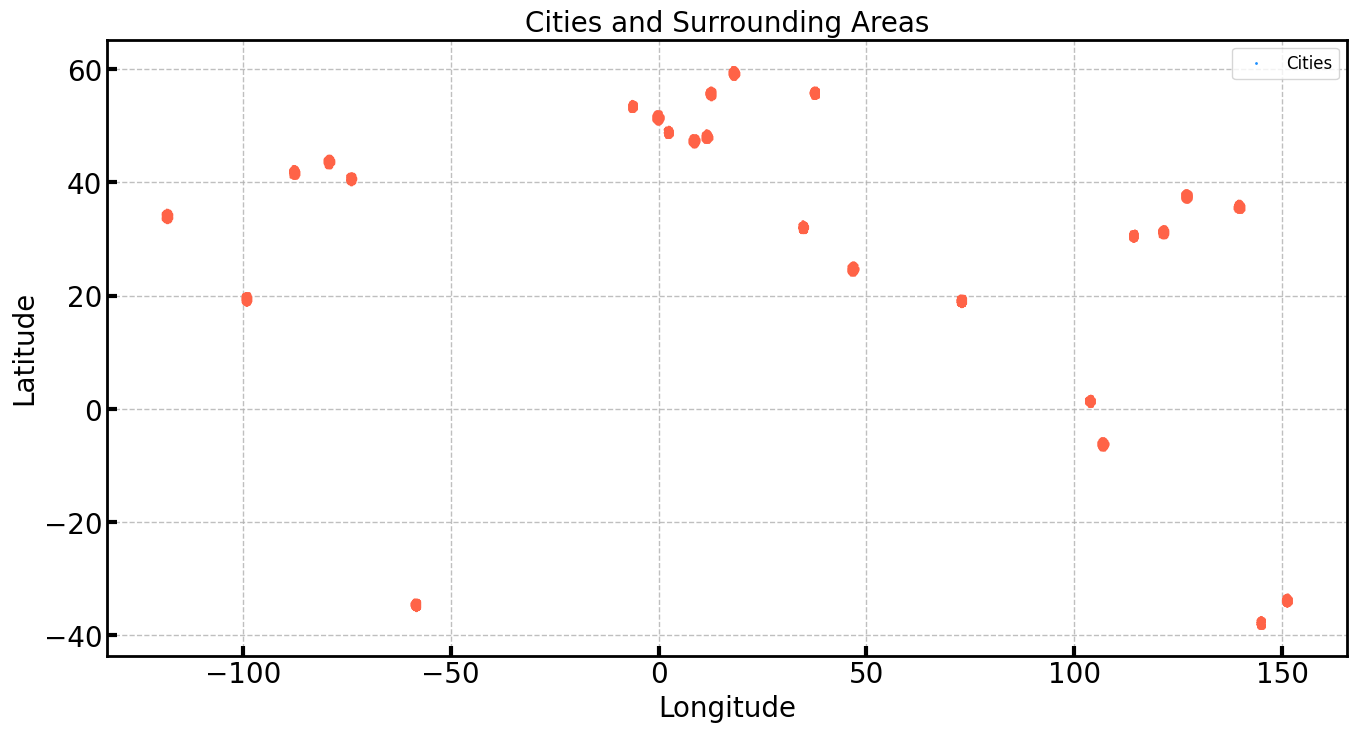

In [17]:
def plotCities(data):
    fig, ax = plt.subplots(figsize=(16, 8))
    # Plot cities as blue dots
    ax.plot(data['Longitude'], data['Latitude'], linestyle='', markersize=2, label='Cities')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Cities and Surrounding Areas')
    
    angularRadius = 1  # Example angular radius
    for _, row in data.iterrows():
        plotCircle(ax, row['Latitude'], row['Longitude'], angularRadius)
    ax.legend()
plotCities(data)

In [15]:
def resample_raster_to_image():
    original_resolution = 15  # 15 arc seconds
    new_resolution = 36  # 36 arc seconds
    resampling_factor = new_resolution / original_resolution

    input_file = 'average_masked_2022.tif'
    image_output_file = 'resampled_2022.png'
    
    with rasterio.open(input_file) as src:
        # Calculate new transform and dimensions
        new_transform = src.transform * src.transform.scale(
            (src.width / resampling_factor) / src.width,
            (src.height / resampling_factor) / src.height
        )
        new_width = int(src.width / resampling_factor)
        new_height = int(src.height / resampling_factor)

        # Read and resample the first band of the data
        data = src.read(1, out_shape=(new_height, new_width), resampling=Resampling.bilinear)
        
        # Normalize the data to 0-255 if necessary, handling no-data values if present
        nodata_value = src.nodatavals[0]
        if nodata_value is not None:
            data[data == nodata_value] = np.nan
        data_min, data_max = np.nanmin(data), np.nanmax(data)
        data_normalized = (data - data_min) / (data_max - data_min) * 255
        data_normalized = np.nan_to_num(data_normalized, nan=0).astype('uint8')
        
        # Save to image using Matplotlib
        plt.imsave(image_output_file, data_normalized, cmap='gray')  # Use an appropriate colormap

# Example usage
resample_raster_to_image()
